In [1]:
import torch.optim as optim
from torch import nn

from preprocessing_last20 import *
from classifier import FaceRecognizer
from mindiffusion.ddpm import DDPM
from mindiffusion.unet import NaiveUnet

In [2]:
device = torch.device('cpu')
train_data.to(device)
test_data.to(device)

classifier = FaceRecognizer().to(device)
ddpm = DDPM(eps_model=NaiveUnet(1, 1, n_feat=128), betas=(1e-4, 0.02), n_T=600).to(device)
attack_targets = torch.tensor([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]).to(device)

In [3]:
classifier.load_state_dict(torch.load('classifier.pt'))
ddpm.load_state_dict(torch.load('ddpm_batched_600_last20.pth'))

<All keys matched successfully>

In [4]:
def sample_ddpm(noise=None):
    ddpm.eval()
    for param in ddpm.parameters():
        param.requires_grad = False
    torch.random.manual_seed(0)
    xh = ddpm.sample(1, (1, 64, 64), device, noise)
    tensor_to_picture(xh[0].detach().cpu().numpy()[0])
    return xh

In [5]:
for param in classifier.parameters():
    param.requires_grad = False
for param in ddpm.parameters():
    param.requires_grad = False


In [6]:
torch.random.manual_seed(0)
x_i = torch.randn(1, 1, 64, 64).to(device)

In [7]:
x_i.requires_grad = True

In [8]:
def optimize_ddpm_noise(noise, optimizer, criterion, target):
    optimizer.zero_grad()
    generated = sample_ddpm(noise)
    result = classifier(generated)
    loss = criterion(result,attack_targets[target])
    loss.backward()
    optimizer.step()
    return loss.item(), generated, result
def optimize_ddpm_noise_eps(noise, eps, lr, lr_decay, target=8):
    for epoch in range(eps): 
        optimizer = optim.SGD([noise], lr=lr*lr_decay**epoch, momentum=0.9, nesterov=False)
        criterion = nn.CrossEntropyLoss(reduction = 'sum')
        epoch_loss, generated, result = optimize_ddpm_noise(noise, optimizer, criterion, target)
        print("loss(generator): ", epoch_loss)
        print(torch.softmax(result,-1))

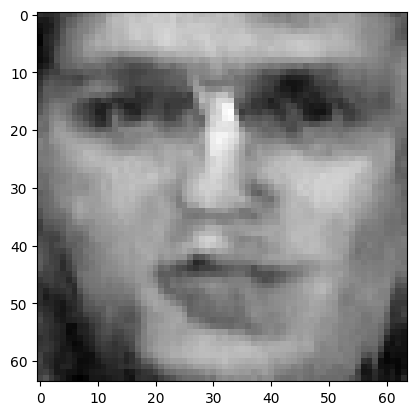

loss(generator):  6.789507865905762
tensor([[3.4526e-05, 9.2428e-07, 1.0886e-05, 8.7313e-07, 1.2574e-05, 1.2392e-09,
         8.8971e-04, 1.4415e-06, 1.1255e-03, 2.7113e-03, 1.5803e-06, 1.9596e-04,
         9.2405e-04, 1.8522e-07, 1.3109e-06, 7.7762e-04, 5.0550e-06, 1.1409e-04,
         1.1031e-04, 8.2322e-05, 1.7868e-04, 3.4803e-05, 1.7662e-07, 2.4909e-02,
         2.8925e-04, 2.1345e-10, 6.2963e-07, 1.4260e-05, 2.0178e-03, 2.9890e-03,
         4.0743e-05, 2.2991e-09, 7.0110e-04, 3.8083e-07, 1.7619e-03, 4.0684e-04,
         2.2281e-07, 5.9380e-05, 1.7524e-04, 9.5942e-01]],
       grad_fn=<SoftmaxBackward>)


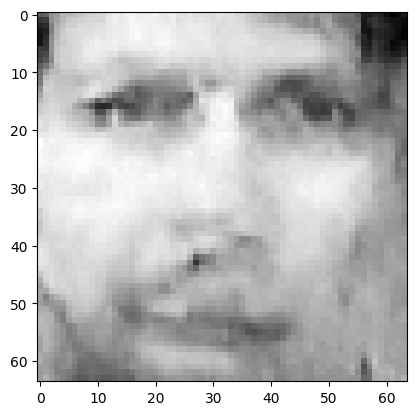

loss(generator):  3.2201714515686035
tensor([[5.1780e-06, 7.0732e-07, 5.2408e-05, 8.6000e-03, 7.6532e-06, 1.5094e-02,
         1.5540e-01, 3.5497e-02, 3.9948e-02, 2.4668e-04, 5.4087e-04, 3.9723e-07,
         8.2678e-05, 5.3009e-07, 4.1411e-03, 7.7270e-06, 2.5568e-04, 3.2803e-01,
         2.1389e-05, 1.3228e-03, 8.0930e-06, 1.0583e-04, 1.6069e-02, 3.0772e-03,
         1.2530e-03, 1.6757e-06, 2.3521e-07, 3.2253e-05, 8.2319e-03, 5.6532e-05,
         7.6053e-07, 1.7518e-06, 2.5466e-02, 4.5269e-06, 3.2737e-01, 2.8736e-04,
         4.6016e-05, 4.2205e-03, 2.4516e-02, 7.4562e-07]],
       grad_fn=<SoftmaxBackward>)


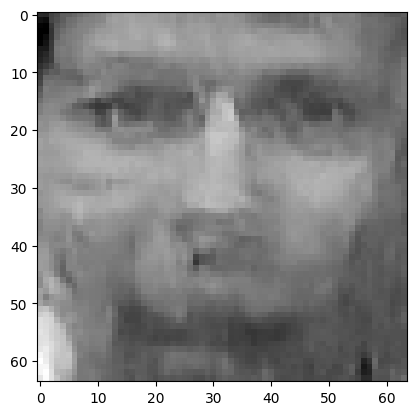

loss(generator):  0.24376720190048218
tensor([[8.5985e-11, 1.0706e-09, 1.2216e-06, 5.7903e-05, 1.1175e-10, 1.3168e-11,
         1.2934e-04, 5.2821e-11, 7.8367e-01, 3.8581e-06, 2.3876e-06, 1.0422e-08,
         9.2727e-05, 5.9418e-08, 6.2539e-08, 1.4000e-11, 2.7152e-02, 1.9848e-12,
         1.8146e-09, 2.0785e-09, 2.9230e-07, 1.5932e-02, 1.5959e-02, 1.1849e-08,
         4.7226e-02, 2.6147e-07, 2.8377e-06, 4.2344e-02, 2.9995e-02, 3.1430e-09,
         1.6826e-04, 8.5351e-10, 1.0661e-04, 2.5198e-07, 3.0092e-05, 2.2716e-11,
         3.3769e-02, 2.4805e-03, 8.7591e-04, 3.9218e-08]],
       grad_fn=<SoftmaxBackward>)


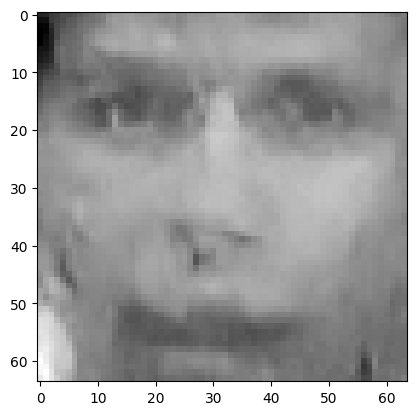

loss(generator):  0.001874001114629209
tensor([[6.1825e-12, 2.4358e-13, 8.7558e-10, 4.7065e-07, 6.1100e-12, 1.2896e-10,
         3.3914e-06, 2.8159e-13, 9.9813e-01, 1.1670e-05, 5.6733e-09, 1.1824e-11,
         2.5898e-07, 3.5361e-14, 2.9633e-09, 3.8610e-10, 2.0938e-06, 4.4610e-10,
         8.2215e-11, 2.2078e-09, 1.3054e-11, 6.5252e-07, 1.0108e-03, 1.3181e-09,
         1.1080e-06, 3.4343e-14, 3.0660e-10, 2.3895e-06, 8.3654e-04, 1.2708e-09,
         4.3913e-10, 1.8646e-13, 2.2710e-06, 2.1550e-12, 6.9853e-08, 6.5306e-11,
         7.1276e-09, 4.9247e-07, 8.0067e-09, 1.8667e-09]],
       grad_fn=<SoftmaxBackward>)


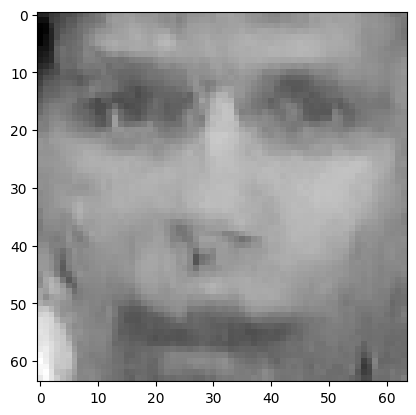

loss(generator):  0.001809508539736271
tensor([[5.7922e-12, 2.3414e-13, 8.3766e-10, 4.4758e-07, 5.8290e-12, 1.1656e-10,
         3.2698e-06, 2.6795e-13, 9.9819e-01, 1.1480e-05, 5.4949e-09, 1.1348e-11,
         2.5604e-07, 3.3095e-14, 2.8709e-09, 3.8640e-10, 2.0097e-06, 4.2499e-10,
         7.9699e-11, 2.2002e-09, 1.2766e-11, 6.4804e-07, 9.3231e-04, 1.3310e-09,
         1.0642e-06, 3.0509e-14, 2.9675e-10, 2.2880e-06, 8.5132e-04, 1.3033e-09,
         4.3035e-10, 1.7112e-13, 2.3069e-06, 2.0940e-12, 6.8533e-08, 6.4215e-11,
         6.7638e-09, 4.7568e-07, 7.9716e-09, 1.8698e-09]],
       grad_fn=<SoftmaxBackward>)


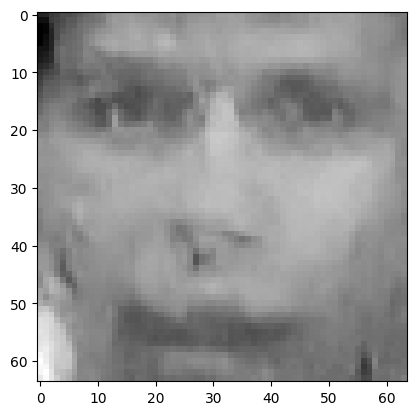

loss(generator):  0.0017563169822096825
tensor([[5.4652e-12, 2.2605e-13, 8.0425e-10, 4.2816e-07, 5.6102e-12, 1.0686e-10,
         3.1651e-06, 2.5583e-13, 9.9825e-01, 1.1325e-05, 5.3391e-09, 1.0961e-11,
         2.5311e-07, 3.1186e-14, 2.7940e-09, 3.8636e-10, 1.9360e-06, 4.0735e-10,
         7.7585e-11, 2.1908e-09, 1.2493e-11, 6.4327e-07, 8.7051e-04, 1.3402e-09,
         1.0277e-06, 2.7571e-14, 2.8843e-10, 2.2030e-06, 8.6038e-04, 1.3305e-09,
         4.2302e-10, 1.5909e-13, 2.3303e-06, 2.0389e-12, 6.7230e-08, 6.3300e-11,
         6.4451e-09, 4.6023e-07, 7.9180e-09, 1.8721e-09]],
       grad_fn=<SoftmaxBackward>)


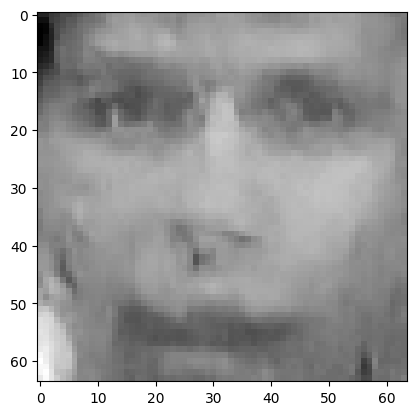

loss(generator):  0.0017101438716053963
tensor([[5.1880e-12, 2.1895e-13, 7.7398e-10, 4.1117e-07, 5.4387e-12, 9.9027e-11,
         3.0736e-06, 2.4478e-13, 9.9829e-01, 1.1190e-05, 5.1987e-09, 1.0645e-11,
         2.5025e-07, 2.9563e-14, 2.7274e-09, 3.8586e-10, 1.8709e-06, 3.9248e-10,
         7.5756e-11, 2.1781e-09, 1.2231e-11, 6.3812e-07, 8.2059e-04, 1.3461e-09,
         9.9714e-07, 2.5255e-14, 2.8124e-10, 2.1299e-06, 8.6470e-04, 1.3533e-09,
         4.1704e-10, 1.4944e-13, 2.3438e-06, 1.9881e-12, 6.5966e-08, 6.2514e-11,
         6.1623e-09, 4.4611e-07, 7.8498e-09, 1.8744e-09]],
       grad_fn=<SoftmaxBackward>)


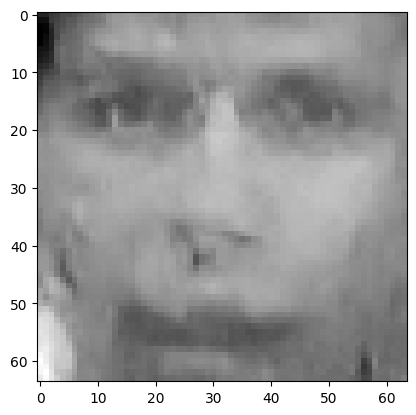

loss(generator):  0.0016688480973243713
tensor([[4.9461e-12, 2.1262e-13, 7.4586e-10, 3.9596e-07, 5.2986e-12, 9.2490e-11,
         2.9918e-06, 2.3457e-13, 9.9833e-01, 1.1070e-05, 5.0698e-09, 1.0376e-11,
         2.4750e-07, 2.8138e-14, 2.6684e-09, 3.8512e-10, 1.8115e-06, 3.7962e-10,
         7.4133e-11, 2.1630e-09, 1.1973e-11, 6.3269e-07, 7.7862e-04, 1.3498e-09,
         9.7087e-07, 2.3349e-14, 2.7490e-10, 2.0650e-06, 8.6567e-04, 1.3732e-09,
         4.1195e-10, 1.4142e-13, 2.3509e-06, 1.9406e-12, 6.4720e-08, 6.1833e-11,
         5.9045e-09, 4.3301e-07, 7.7712e-09, 1.8766e-09]],
       grad_fn=<SoftmaxBackward>)


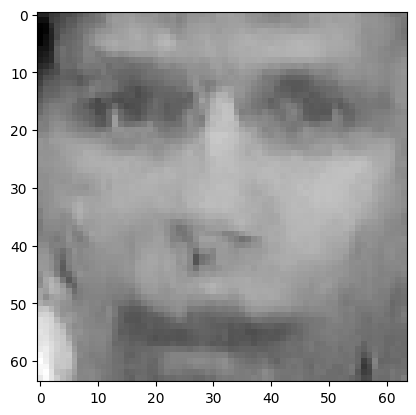

loss(generator):  0.0016314780805259943
tensor([[4.7338e-12, 2.0690e-13, 7.2012e-10, 3.8243e-07, 5.1849e-12, 8.6984e-11,
         2.9182e-06, 2.2515e-13, 9.9837e-01, 1.0964e-05, 4.9508e-09, 1.0147e-11,
         2.4482e-07, 2.6883e-14, 2.6159e-09, 3.8404e-10, 1.7575e-06, 3.6831e-10,
         7.2686e-11, 2.1465e-09, 1.1727e-11, 6.2718e-07, 7.4349e-04, 1.3514e-09,
         9.4802e-07, 2.1776e-14, 2.6927e-10, 2.0076e-06, 8.6382e-04, 1.3900e-09,
         4.0761e-10, 1.3469e-13, 2.3519e-06, 1.8960e-12, 6.3508e-08, 6.1224e-11,
         5.6718e-09, 4.2078e-07, 7.6851e-09, 1.8785e-09]],
       grad_fn=<SoftmaxBackward>)


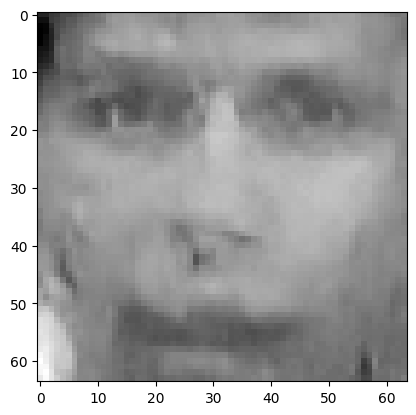

loss(generator):  0.001597201102413237
tensor([[4.5471e-12, 2.0175e-13, 6.9647e-10, 3.7036e-07, 5.0939e-12, 8.2340e-11,
         2.8520e-06, 2.1646e-13, 9.9840e-01, 1.0871e-05, 4.8413e-09, 9.9539e-12,
         2.4221e-07, 2.5772e-14, 2.5694e-09, 3.8280e-10, 1.7082e-06, 3.5845e-10,
         7.1404e-11, 2.1290e-09, 1.1491e-11, 6.2155e-07, 7.1390e-04, 1.3513e-09,
         9.2807e-07, 2.0468e-14, 2.6428e-10, 1.9567e-06, 8.5949e-04, 1.4040e-09,
         4.0387e-10, 1.2903e-13, 2.3475e-06, 1.8543e-12, 6.2327e-08, 6.0687e-11,
         5.4594e-09, 4.0935e-07, 7.5919e-09, 1.8804e-09]],
       grad_fn=<SoftmaxBackward>)


In [9]:
optimize_ddpm_noise_eps(x_i, 10, 10, 1, target=8)

In [12]:
torch.save(x_i, 'attack8_lr10.pt')

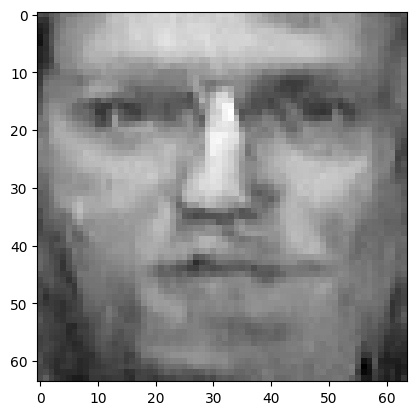

loss(generator):  8.239416122436523
tensor([[6.8469e-03, 1.1939e-04, 1.3764e-02, 1.3573e-04, 3.3857e-04, 3.1897e-09,
         4.5285e-03, 3.2587e-05, 2.6404e-04, 7.0528e-04, 1.4046e-05, 7.5045e-03,
         4.8018e-02, 5.7733e-03, 1.4848e-06, 3.7232e-06, 1.8843e-02, 2.1746e-06,
         1.5270e-04, 1.7531e-05, 1.7062e-01, 1.1246e-01, 2.9204e-05, 2.5055e-03,
         5.0159e-03, 3.2102e-05, 4.0081e-05, 2.8523e-03, 1.6960e-02, 6.3383e-04,
         6.2885e-02, 2.0070e-06, 1.7373e-02, 4.3653e-04, 3.1665e-02, 9.1691e-05,
         1.4790e-01, 1.4217e-01, 1.2716e-01, 5.2101e-02]],
       grad_fn=<SoftmaxBackward>)


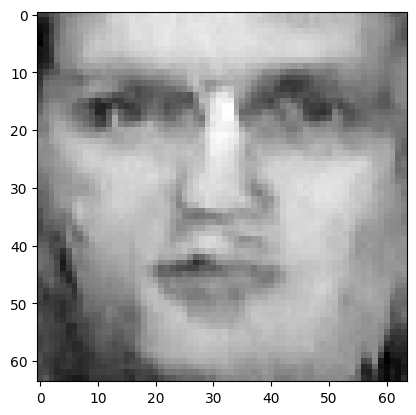

loss(generator):  5.148725509643555
tensor([[1.2413e-01, 2.7451e-06, 7.1828e-05, 7.2007e-06, 8.8173e-03, 2.1565e-04,
         6.2485e-02, 3.5989e-04, 5.8068e-03, 6.8346e-02, 7.5412e-06, 1.3229e-02,
         1.2789e-02, 6.1143e-06, 2.6148e-06, 2.3592e-03, 4.4678e-04, 1.7985e-01,
         1.6804e-04, 1.5454e-05, 2.3461e-05, 3.3057e-05, 9.6264e-04, 8.0717e-03,
         2.0638e-02, 5.2493e-07, 2.5768e-06, 6.6948e-05, 3.0044e-04, 6.0313e-04,
         8.6237e-05, 8.6325e-06, 1.5087e-03, 1.7637e-07, 2.0813e-02, 4.6131e-03,
         3.6767e-06, 3.3070e-03, 8.7366e-05, 4.5976e-01]],
       grad_fn=<SoftmaxBackward>)


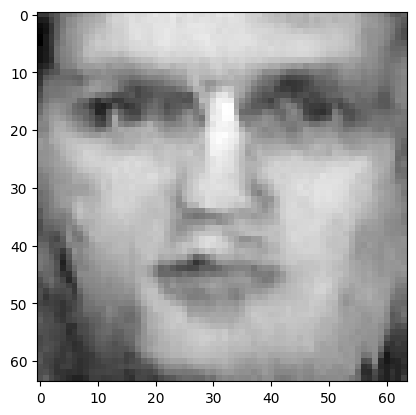

loss(generator):  3.90150785446167
tensor([[3.4003e-02, 2.2448e-06, 5.8917e-05, 1.1242e-05, 7.3317e-03, 3.4812e-04,
         9.0076e-02, 3.7388e-04, 2.0211e-02, 5.8395e-02, 1.3836e-05, 4.7981e-03,
         1.0457e-02, 3.6452e-06, 1.0796e-05, 3.1515e-03, 3.6919e-04, 4.1547e-01,
         1.4572e-04, 4.5867e-05, 2.8645e-05, 4.1571e-05, 1.3805e-03, 1.2702e-02,
         2.4201e-02, 2.3659e-07, 1.9387e-06, 5.1525e-05, 7.5442e-04, 2.1008e-03,
         8.2325e-05, 5.5184e-06, 4.8477e-03, 3.5518e-07, 6.1618e-02, 8.7695e-03,
         3.1943e-06, 5.4947e-03, 1.7474e-04, 2.3246e-01]],
       grad_fn=<SoftmaxBackward>)


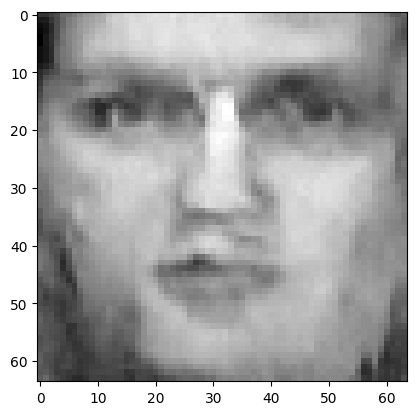

loss(generator):  3.0329082012176514
tensor([[1.7333e-02, 1.8287e-06, 1.4332e-04, 1.1243e-05, 2.7425e-03, 7.8863e-05,
         5.7356e-02, 3.3761e-04, 4.8175e-02, 6.9952e-02, 1.6834e-05, 2.4224e-03,
         1.1525e-02, 3.0718e-06, 9.4808e-06, 3.1221e-03, 3.9880e-04, 1.5053e-01,
         1.0357e-04, 1.2073e-04, 9.7757e-05, 8.5217e-05, 6.9228e-04, 1.2176e-02,
         1.4919e-02, 6.9288e-08, 1.8018e-06, 5.9660e-05, 4.2570e-03, 7.1515e-03,
         9.2322e-05, 8.6627e-07, 1.4835e-02, 6.2832e-07, 1.3378e-01, 4.8065e-03,
         6.1823e-06, 1.4802e-02, 4.0336e-04, 4.2744e-01]],
       grad_fn=<SoftmaxBackward>)


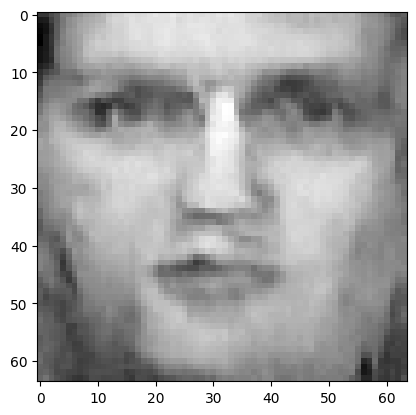

loss(generator):  2.066793203353882
tensor([[1.6601e-02, 3.0236e-06, 3.3364e-04, 2.2611e-05, 6.8193e-03, 5.1499e-04,
         6.9881e-02, 2.5444e-04, 1.2659e-01, 7.5487e-02, 3.5000e-05, 5.3014e-03,
         1.0148e-02, 9.0674e-06, 9.9865e-06, 2.5074e-03, 7.5936e-04, 2.3490e-01,
         1.4133e-04, 7.0264e-05, 6.4522e-05, 1.3181e-04, 3.2958e-03, 2.3562e-03,
         3.8799e-02, 6.0493e-07, 8.6955e-06, 1.1585e-04, 2.1586e-03, 4.6182e-03,
         1.5732e-04, 7.6164e-06, 1.2575e-02, 8.5347e-07, 5.7997e-02, 2.2897e-03,
         1.0841e-05, 4.9122e-02, 2.0347e-04, 2.7570e-01]],
       grad_fn=<SoftmaxBackward>)


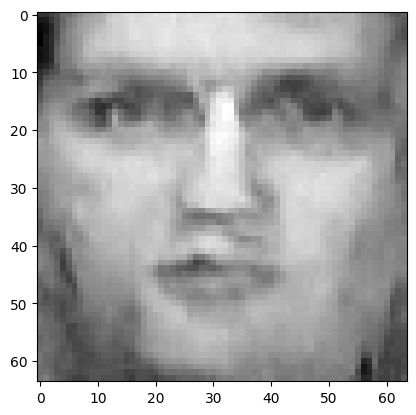

loss(generator):  1.369605541229248
tensor([[8.4225e-03, 1.5110e-06, 4.9014e-04, 1.5973e-05, 1.8559e-03, 1.6505e-04,
         4.6358e-02, 1.9464e-04, 2.5421e-01, 8.8404e-02, 3.0219e-05, 1.8961e-03,
         8.8932e-03, 4.0676e-06, 5.0091e-06, 1.8561e-03, 6.6906e-04, 7.7660e-02,
         7.1487e-05, 8.8294e-05, 6.4521e-05, 1.8876e-04, 1.8975e-03, 1.2787e-03,
         2.0979e-02, 1.2815e-07, 5.8536e-06, 9.8129e-05, 7.7129e-03, 8.0362e-03,
         9.0354e-05, 1.2867e-06, 2.6162e-02, 6.8999e-07, 6.9256e-02, 9.4945e-04,
         1.2625e-05, 1.0219e-01, 2.3232e-04, 2.6956e-01]],
       grad_fn=<SoftmaxBackward>)


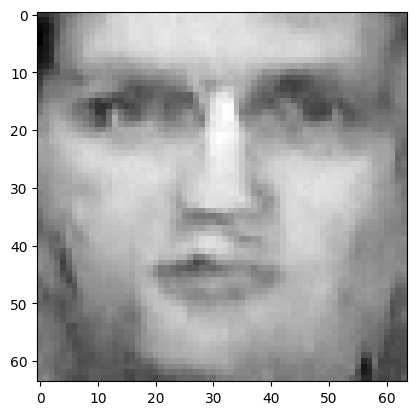

loss(generator):  0.9406154155731201
tensor([[4.9430e-03, 1.1066e-06, 2.6789e-04, 1.4638e-05, 1.8672e-03, 4.1984e-04,
         5.3674e-02, 1.6125e-04, 3.9039e-01, 9.0002e-02, 3.4240e-05, 9.8505e-04,
         6.9389e-03, 2.0268e-06, 6.5091e-06, 1.9443e-03, 5.6373e-04, 1.2375e-01,
         5.2632e-05, 7.7352e-05, 2.0308e-05, 1.4467e-04, 3.1027e-03, 8.4958e-04,
         2.5648e-02, 9.2480e-08, 4.8613e-06, 7.4767e-05, 5.8650e-03, 7.3213e-03,
         6.1996e-05, 1.7181e-06, 2.4819e-02, 4.6461e-07, 5.6055e-02, 1.0813e-03,
         6.9323e-06, 7.7435e-02, 1.4076e-04, 1.2127e-01]],
       grad_fn=<SoftmaxBackward>)


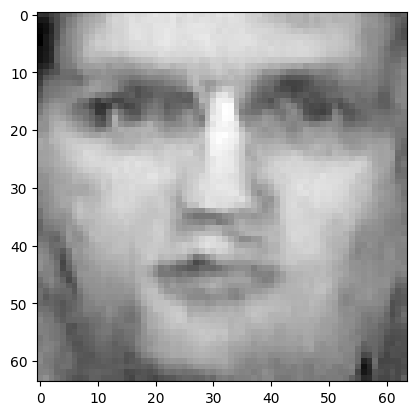

loss(generator):  0.6729034185409546
tensor([[2.2614e-03, 7.5048e-07, 2.2916e-04, 9.3893e-06, 1.0647e-03, 2.1747e-04,
         3.1597e-02, 8.5035e-05, 5.1022e-01, 7.2087e-02, 2.9282e-05, 5.5165e-04,
         5.0744e-03, 1.1962e-06, 3.9362e-06, 1.4743e-03, 4.4816e-04, 6.0092e-02,
         3.1392e-05, 6.9189e-05, 1.5309e-05, 1.5230e-04, 1.8813e-03, 4.0702e-04,
         1.8214e-02, 4.0776e-08, 4.0667e-06, 5.6478e-05, 7.1752e-03, 9.2474e-03,
         5.1459e-05, 8.0229e-07, 2.8099e-02, 3.6429e-07, 4.0372e-02, 5.6457e-04,
         5.4750e-06, 9.7664e-02, 1.1042e-04, 1.1043e-01]],
       grad_fn=<SoftmaxBackward>)


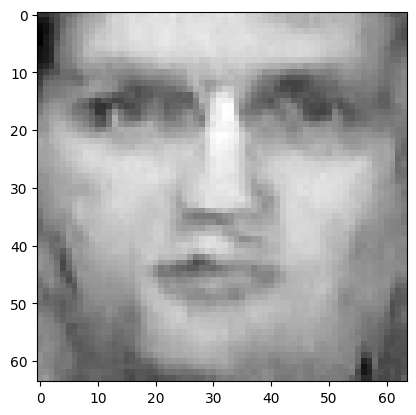

loss(generator):  0.48739364743232727
tensor([[1.0960e-03, 5.4796e-07, 1.2482e-04, 6.6238e-06, 8.7483e-04, 2.3610e-04,
         2.4952e-02, 5.2172e-05, 6.1423e-01, 6.0455e-02, 2.6522e-05, 2.8560e-04,
         3.6868e-03, 5.7688e-07, 3.9740e-06, 1.4897e-03, 3.1222e-04, 5.8618e-02,
         2.1418e-05, 6.5902e-05, 7.1752e-06, 1.1853e-04, 1.5646e-03, 2.8457e-04,
         1.5831e-02, 1.9110e-08, 2.8808e-06, 3.7853e-05, 6.0688e-03, 1.0398e-02,
         3.9738e-05, 6.0831e-07, 2.6226e-02, 2.5892e-07, 3.0044e-02, 5.3851e-04,
         2.8838e-06, 6.8212e-02, 7.4201e-05, 7.4013e-02]],
       grad_fn=<SoftmaxBackward>)


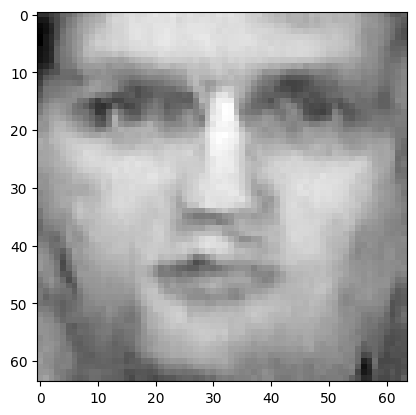

loss(generator):  0.35791030526161194
tensor([[5.0423e-04, 4.0090e-07, 7.4071e-05, 4.3069e-06, 6.5097e-04, 1.9819e-04,
         1.6845e-02, 2.8883e-05, 6.9914e-01, 4.6124e-02, 2.2974e-05, 1.5138e-04,
         2.5928e-03, 3.0018e-07, 3.3074e-06, 1.3885e-03, 2.2060e-04, 4.5016e-02,
         1.3588e-05, 6.0398e-05, 3.9020e-06, 9.6762e-05, 1.0702e-03, 1.7107e-04,
         1.2564e-02, 8.6568e-09, 2.0763e-06, 2.5451e-05, 5.3355e-03, 1.1843e-02,
         3.2107e-05, 3.9962e-07, 2.4262e-02, 1.8863e-07, 2.0756e-02, 4.1431e-04,
         1.6572e-06, 5.4568e-02, 5.0552e-05, 5.5768e-02]],
       grad_fn=<SoftmaxBackward>)


In [14]:
torch.random.manual_seed(0)
x_i_lr1 = torch.randn(1, 1, 64, 64).to(device)
x_i_lr1.requires_grad = True
optimize_ddpm_noise_eps(x_i_lr1, 10, 1, 1, target=8)

In [15]:
torch.save(x_i_lr1, 'attack8_lr1.pt')

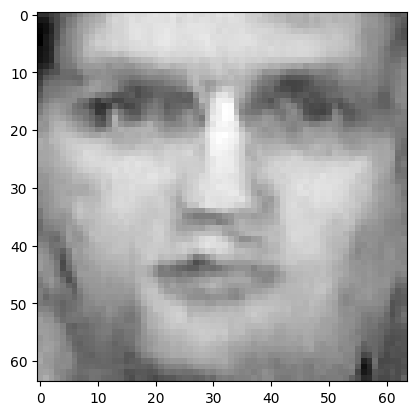

loss(generator):  0.2609539031982422
tensor([[2.1793e-04, 2.9234e-07, 4.2305e-05, 2.6801e-06, 4.7917e-04, 1.6069e-04,
         1.0820e-02, 1.5121e-05, 7.7032e-01, 3.2543e-02, 1.9106e-05, 7.8888e-05,
         1.7562e-03, 1.5478e-07, 2.6619e-06, 1.2923e-03, 1.5266e-04, 3.3603e-02,
         8.3158e-06, 5.4549e-05, 2.1440e-06, 7.6532e-05, 6.6176e-04, 9.9796e-05,
         9.7555e-03, 3.7781e-09, 1.4492e-06, 1.6265e-05, 4.4650e-03, 1.3434e-02,
         2.6343e-05, 2.5715e-07, 2.1657e-02, 1.3640e-07, 1.3658e-02, 3.0732e-04,
         9.1586e-07, 4.2658e-02, 3.3700e-05, 4.1581e-02]],
       grad_fn=<SoftmaxBackward>)


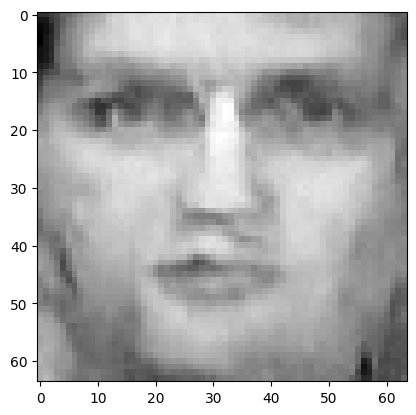

loss(generator):  0.20371615886688232
tensor([[1.0881e-04, 2.2683e-07, 2.5936e-05, 1.7749e-06, 3.7324e-04, 1.3420e-04,
         7.4323e-03, 8.7153e-06, 8.1569e-01, 2.3764e-02, 1.6420e-05, 4.6859e-05,
         1.2500e-03, 9.0337e-08, 2.2165e-06, 1.2233e-03, 1.1205e-04, 2.6707e-02,
         5.5150e-06, 4.9082e-05, 1.2955e-06, 6.2084e-05, 4.3563e-04, 6.3347e-05,
         7.7090e-03, 1.8840e-09, 1.0761e-06, 1.0918e-05, 3.7660e-03, 1.4820e-02,
         2.2134e-05, 1.8170e-07, 1.9323e-02, 1.0470e-07, 9.5548e-03, 2.3691e-04,
         5.5231e-07, 3.4494e-02, 2.3836e-05, 3.2520e-02]],
       grad_fn=<SoftmaxBackward>)


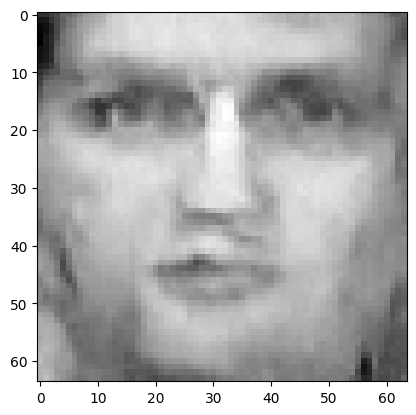

loss(generator):  0.17603524029254913
tensor([[7.7947e-05, 1.8532e-07, 2.1069e-05, 1.4419e-06, 3.2257e-04, 1.1603e-04,
         6.2254e-03, 6.5734e-06, 8.3859e-01, 2.1002e-02, 1.4549e-05, 3.6090e-05,
         1.0232e-03, 6.6519e-08, 1.9253e-06, 1.1303e-03, 9.7063e-05, 2.1856e-02,
         4.4324e-06, 4.5434e-05, 1.0180e-06, 5.6328e-05, 3.6268e-04, 5.0341e-05,
         6.4593e-03, 1.3274e-09, 8.9194e-07, 9.0408e-06, 3.4794e-03, 1.4781e-02,
         1.9625e-05, 1.4243e-07, 1.7979e-02, 8.8486e-08, 8.0734e-03, 2.0166e-04,
         4.4018e-07, 2.9915e-02, 1.9852e-05, 2.8021e-02]],
       grad_fn=<SoftmaxBackward>)


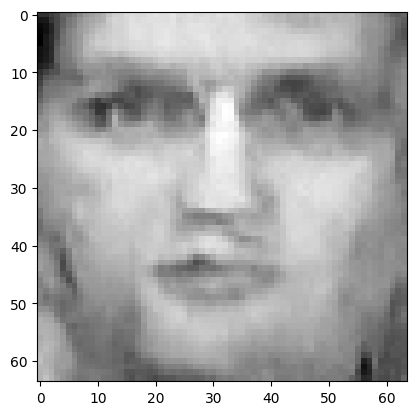

loss(generator):  0.1580464094877243
tensor([[6.5617e-05, 1.5404e-07, 1.9850e-05, 1.3048e-06, 2.9281e-04, 1.0097e-04,
         5.7069e-03, 5.5935e-06, 8.5381e-01, 2.0151e-02, 1.2912e-05, 3.1588e-05,
         8.9994e-04, 5.5369e-08, 1.6903e-06, 1.0035e-03, 9.1641e-05, 1.7879e-02,
         3.8779e-06, 4.2575e-05, 9.2287e-07, 5.4207e-05, 3.4152e-04, 4.4070e-05,
         5.6288e-03, 1.1399e-09, 7.7946e-07, 8.4340e-06, 3.3413e-03, 1.3729e-02,
         1.8127e-05, 1.1628e-07, 1.6940e-02, 7.7902e-08, 7.4508e-03, 1.7662e-04,
         4.0847e-07, 2.6884e-02, 1.7997e-05, 2.5241e-02]],
       grad_fn=<SoftmaxBackward>)


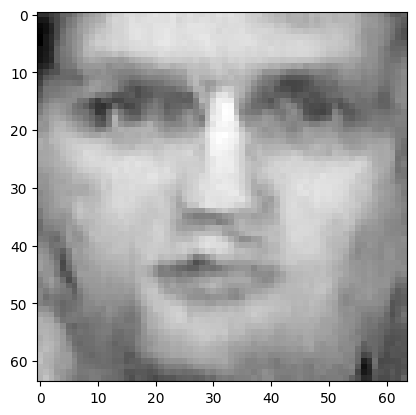

loss(generator):  0.14382894337177277
tensor([[5.8359e-05, 1.3093e-07, 1.9445e-05, 1.2311e-06, 2.7336e-04, 9.0437e-05,
         5.3929e-03, 4.9427e-06, 8.6604e-01, 1.9710e-02, 1.1585e-05, 2.9014e-05,
         8.1255e-04, 4.8501e-08, 1.5097e-06, 8.8411e-04, 8.9366e-05, 1.4958e-02,
         3.5054e-06, 3.9893e-05, 8.6855e-07, 5.3015e-05, 3.3860e-04, 3.9599e-05,
         5.0410e-03, 1.0619e-09, 7.0265e-07, 8.1818e-06, 3.2053e-03, 1.2425e-02,
         1.7089e-05, 9.9523e-08, 1.5924e-02, 6.9908e-08, 7.0166e-03, 1.5704e-04,
         3.9732e-07, 2.4485e-02, 1.6694e-05, 2.2854e-02]],
       grad_fn=<SoftmaxBackward>)


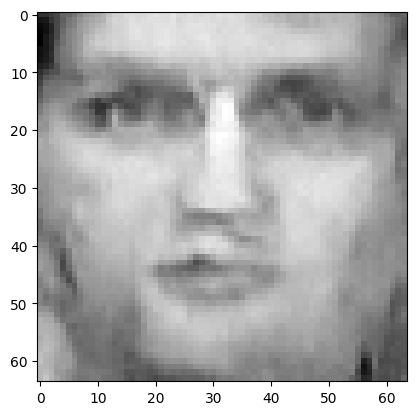

loss(generator):  0.13220208883285522
tensor([[5.2477e-05, 1.1371e-07, 1.8892e-05, 1.1705e-06, 2.5894e-04, 8.2995e-05,
         5.1406e-03, 4.4135e-06, 8.7616e-01, 1.9283e-02, 1.0556e-05, 2.6892e-05,
         7.4206e-04, 4.3021e-08, 1.3768e-06, 7.9309e-04, 8.7369e-05, 1.2918e-02,
         3.2086e-06, 3.7598e-05, 8.1417e-07, 5.1768e-05, 3.3823e-04, 3.6039e-05,
         4.5882e-03, 9.9847e-10, 6.4173e-07, 7.9472e-06, 3.0610e-03, 1.1341e-02,
         1.6218e-05, 8.7886e-08, 1.5001e-02, 6.3406e-08, 6.6244e-03, 1.4255e-04,
         3.8498e-07, 2.2355e-02, 1.5551e-05, 2.0794e-02]],
       grad_fn=<SoftmaxBackward>)


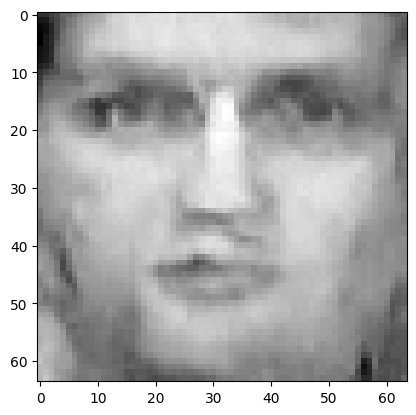

loss(generator):  0.12242448329925537
tensor([[4.7464e-05, 9.9920e-08, 1.8331e-05, 1.1168e-06, 2.4687e-04, 7.6774e-05,
         4.9131e-03, 3.9657e-06, 8.8477e-01, 1.8835e-02, 9.6899e-06, 2.5054e-05,
         6.8194e-04, 3.8538e-08, 1.2675e-06, 7.1635e-04, 8.5421e-05, 1.1307e-02,
         2.9527e-06, 3.5607e-05, 7.6653e-07, 5.0575e-05, 3.3788e-04, 3.3003e-05,
         4.2089e-03, 9.4411e-10, 5.8939e-07, 7.7269e-06, 2.9248e-03, 1.0429e-02,
         1.5471e-05, 7.8493e-08, 1.4190e-02, 5.8007e-08, 6.2845e-03, 1.3050e-04,
         3.7326e-07, 2.0539e-02, 1.4564e-05, 1.9052e-02]],
       grad_fn=<SoftmaxBackward>)


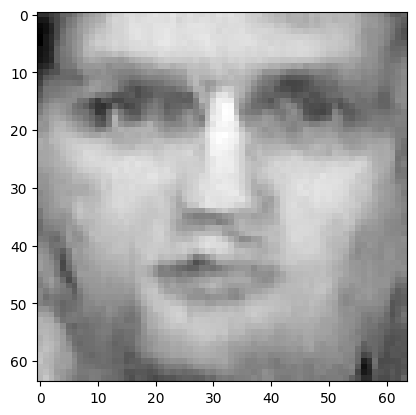

loss(generator):  0.1140296533703804
tensor([[4.3015e-05, 8.8888e-08, 1.7706e-05, 1.0676e-06, 2.3638e-04, 7.1537e-05,
         4.6949e-03, 3.5731e-06, 8.9223e-01, 1.8352e-02, 8.9685e-06, 2.3406e-05,
         6.3000e-04, 3.4754e-08, 1.1766e-06, 6.5172e-04, 8.3428e-05, 1.0019e-02,
         2.7307e-06, 3.3834e-05, 7.2137e-07, 4.9435e-05, 3.3718e-04, 3.0294e-05,
         3.8894e-03, 8.9429e-10, 5.4534e-07, 7.5036e-06, 2.7945e-03, 9.6691e-03,
         1.4817e-05, 7.0959e-08, 1.3465e-02, 5.3441e-08, 5.9614e-03, 1.2022e-04,
         3.6119e-07, 1.8994e-02, 1.3669e-05, 1.7546e-02]],
       grad_fn=<SoftmaxBackward>)


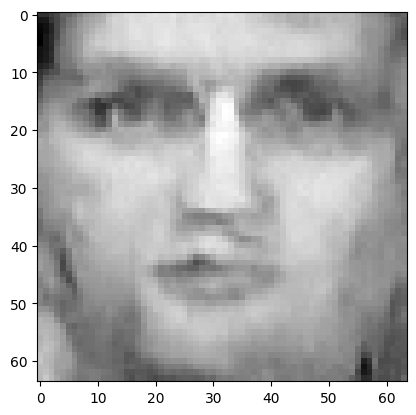

loss(generator):  0.1067076250910759
tensor([[3.9061e-05, 7.9919e-08, 1.6989e-05, 1.0226e-06, 2.2738e-04, 6.7452e-05,
         4.4968e-03, 3.2352e-06, 8.9879e-01, 1.7840e-02, 8.3703e-06, 2.1876e-05,
         5.8511e-04, 3.1475e-08, 1.1042e-06, 5.9884e-04, 8.1370e-05, 9.0203e-03,
         2.5356e-06, 3.2254e-05, 6.7650e-07, 4.8227e-05, 3.3652e-04, 2.7947e-05,
         3.6184e-03, 8.4650e-10, 5.0687e-07, 7.2703e-06, 2.6684e-03, 9.0345e-03,
         1.4214e-05, 6.5010e-08, 1.2817e-02, 4.9526e-08, 5.6602e-03, 1.1184e-04,
         3.4781e-07, 1.7621e-02, 1.2852e-05, 1.6188e-02]],
       grad_fn=<SoftmaxBackward>)


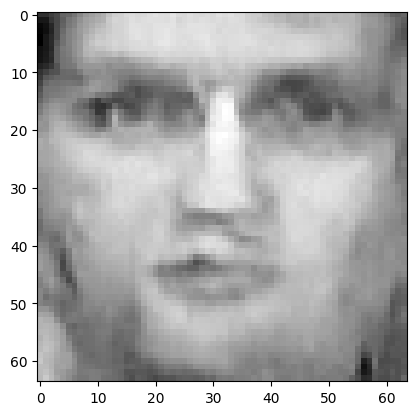

loss(generator):  0.10040520876646042
tensor([[3.5579e-05, 7.2341e-08, 1.6343e-05, 9.7995e-07, 2.1914e-04, 6.3147e-05,
         4.3019e-03, 2.9397e-06, 9.0447e-01, 1.7324e-02, 7.8350e-06, 2.0570e-05,
         5.4538e-04, 2.8723e-08, 1.0389e-06, 5.5126e-04, 7.9454e-05, 8.1469e-03,
         2.3631e-06, 3.0895e-05, 6.4142e-07, 4.7223e-05, 3.3386e-04, 2.5938e-05,
         3.3723e-03, 8.0295e-10, 4.7281e-07, 7.0531e-06, 2.5581e-03, 8.5106e-03,
         1.3712e-05, 5.9596e-08, 1.2264e-02, 4.6200e-08, 5.4027e-03, 1.0426e-04,
         3.3618e-07, 1.6466e-02, 1.2184e-05, 1.5060e-02]],
       grad_fn=<SoftmaxBackward>)


In [16]:
optimize_ddpm_noise_eps(x_i_lr1, 10, 1, 1, target=8)

In [17]:
torch.save(x_i_lr1, 'attack8_lr1_20ep.pt')

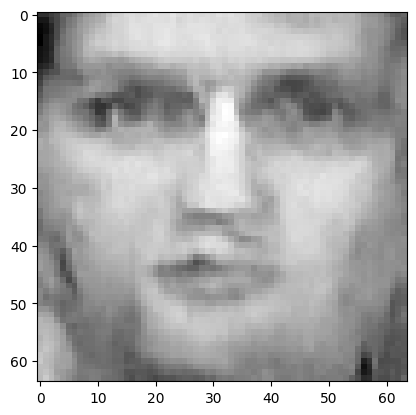

loss(generator):  0.0948207825422287
tensor([[3.2480e-05, 6.5985e-08, 1.5668e-05, 9.3818e-07, 2.1207e-04, 5.9532e-05,
         4.1228e-03, 2.6766e-06, 9.0954e-01, 1.6791e-02, 7.3720e-06, 1.9377e-05,
         5.0963e-04, 2.6327e-08, 9.8170e-07, 5.1094e-04, 7.7597e-05, 7.4295e-03,
         2.2088e-06, 2.9626e-05, 6.0703e-07, 4.6203e-05, 3.3046e-04, 2.4115e-05,
         3.1602e-03, 7.6217e-10, 4.4272e-07, 6.8325e-06, 2.4496e-03, 8.0648e-03,
         1.3274e-05, 5.5142e-08, 1.1757e-02, 4.3268e-08, 5.1597e-03, 9.7764e-05,
         3.2397e-07, 1.5450e-02, 1.1558e-05, 1.4067e-02]],
       grad_fn=<SoftmaxBackward>)


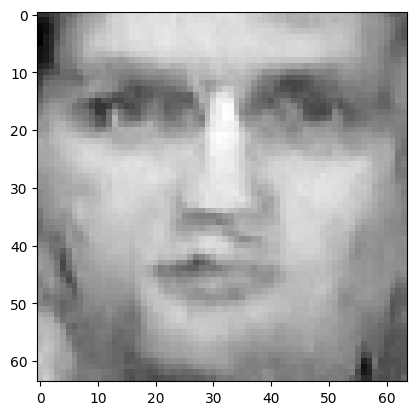

loss(generator):  0.08980440348386765
tensor([[2.9673e-05, 6.0586e-08, 1.4992e-05, 8.9866e-07, 2.0566e-04, 5.6303e-05,
         3.9529e-03, 2.4401e-06, 9.1411e-01, 1.6242e-02, 6.9659e-06, 1.8299e-05,
         4.7711e-04, 2.4239e-08, 9.3126e-07, 4.7547e-04, 7.5709e-05, 6.8233e-03,
         2.0717e-06, 2.8432e-05, 5.7480e-07, 4.5197e-05, 3.2630e-04, 2.2453e-05,
         2.9754e-03, 7.2479e-10, 4.1652e-07, 6.6133e-06, 2.3440e-03, 7.6787e-03,
         1.2886e-05, 5.1395e-08, 1.1286e-02, 4.0675e-08, 4.9250e-03, 9.1953e-05,
         3.1164e-07, 1.4565e-02, 1.0974e-05, 1.3186e-02]],
       grad_fn=<SoftmaxBackward>)


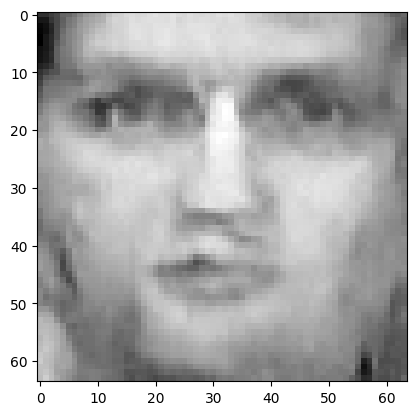

loss(generator):  0.08514061570167542
tensor([[2.7046e-05, 5.5831e-08, 1.4353e-05, 8.6062e-07, 1.9842e-04, 5.2893e-05,
         3.7688e-03, 2.2199e-06, 9.1838e-01, 1.5679e-02, 6.5995e-06, 1.7274e-05,
         4.4649e-04, 2.2361e-08, 8.8198e-07, 4.4202e-04, 7.3808e-05, 6.2372e-03,
         1.9438e-06, 2.7297e-05, 5.4547e-07, 4.4358e-05, 3.2067e-04, 2.0820e-05,
         2.7983e-03, 6.8786e-10, 3.9369e-07, 6.3997e-06, 2.2514e-03, 7.3365e-03,
         1.2510e-05, 4.7829e-08, 1.0848e-02, 3.8349e-08, 4.6845e-03, 8.6025e-05,
         3.0050e-07, 1.3825e-02, 1.0433e-05, 1.2373e-02]],
       grad_fn=<SoftmaxBackward>)


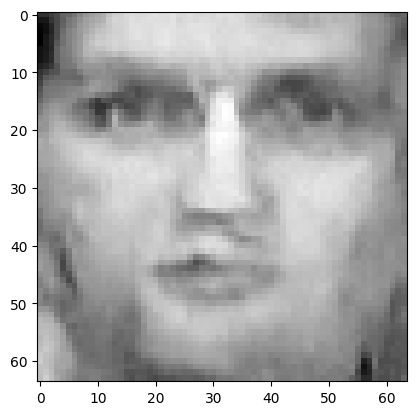

loss(generator):  0.08099380135536194
tensor([[2.4436e-05, 5.1256e-08, 1.3792e-05, 8.2333e-07, 1.8914e-04, 4.8259e-05,
         3.5669e-03, 2.0210e-06, 9.2220e-01, 1.5114e-02, 6.2397e-06, 1.6247e-05,
         4.1724e-04, 2.0562e-08, 8.3596e-07, 4.0916e-04, 7.1491e-05, 5.6421e-03,
         1.8239e-06, 2.6519e-05, 5.2684e-07, 4.3754e-05, 3.1022e-04, 1.9521e-05,
         2.6055e-03, 6.4369e-10, 3.6974e-07, 6.1793e-06, 2.1923e-03, 7.0919e-03,
         1.2136e-05, 4.3388e-08, 1.0523e-02, 3.6321e-08, 4.4965e-03, 8.0264e-05,
         2.9069e-07, 1.3158e-02, 1.0053e-05, 1.1698e-02]],
       grad_fn=<SoftmaxBackward>)


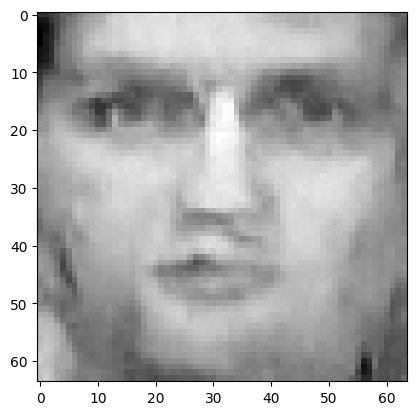

loss(generator):  0.07719649374485016
tensor([[2.2211e-05, 4.7241e-08, 1.3306e-05, 7.9163e-07, 1.8073e-04, 4.4226e-05,
         3.3833e-03, 1.8472e-06, 9.2571e-01, 1.4601e-02, 5.9112e-06, 1.5352e-05,
         3.9122e-04, 1.9018e-08, 7.9388e-07, 3.7886e-04, 6.9406e-05, 5.1181e-03,
         1.7174e-06, 2.5761e-05, 5.1036e-07, 4.3230e-05, 3.0167e-04, 1.8327e-05,
         2.4352e-03, 6.0727e-10, 3.4890e-07, 5.9895e-06, 2.1358e-03, 6.8407e-03,
         1.1793e-05, 3.9586e-08, 1.0205e-02, 3.4481e-08, 4.3172e-03, 7.4953e-05,
         2.8247e-07, 1.2558e-02, 9.6978e-06, 1.1078e-02]],
       grad_fn=<SoftmaxBackward>)


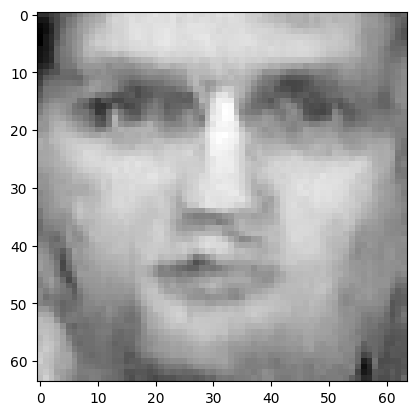

loss(generator):  0.07374919950962067
tensor([[2.0414e-05, 4.3733e-08, 1.2925e-05, 7.6700e-07, 1.7383e-04, 4.0950e-05,
         3.2321e-03, 1.7020e-06, 9.2890e-01, 1.4181e-02, 5.6118e-06, 1.4626e-05,
         3.6907e-04, 1.7735e-08, 7.5636e-07, 3.5169e-04, 6.7802e-05, 4.6699e-03,
         1.6272e-06, 2.5028e-05, 4.9641e-07, 4.2786e-05, 2.9645e-04, 1.7293e-05,
         2.2894e-03, 5.8112e-10, 3.3108e-07, 5.8466e-06, 2.0792e-03, 6.5633e-03,
         1.1491e-05, 3.6480e-08, 9.8850e-03, 3.2815e-08, 4.1557e-03, 7.0324e-05,
         2.7623e-07, 1.1992e-02, 9.3725e-06, 1.0507e-02]],
       grad_fn=<SoftmaxBackward>)


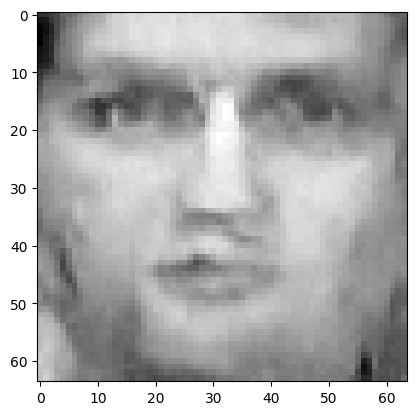

loss(generator):  0.07053207606077194
tensor([[1.8774e-05, 4.0556e-08, 1.2576e-05, 7.4364e-07, 1.6703e-04, 3.7866e-05,
         3.0837e-03, 1.5692e-06, 9.3190e-01, 1.3764e-02, 5.3331e-06, 1.3947e-05,
         3.4870e-04, 1.6584e-08, 7.2011e-07, 3.2631e-04, 6.6288e-05, 4.2600e-03,
         1.5417e-06, 2.4320e-05, 4.8374e-07, 4.2408e-05, 2.9119e-04, 1.6299e-05,
         2.1525e-03, 5.5652e-10, 3.1485e-07, 5.7105e-06, 2.0268e-03, 6.3017e-03,
         1.1204e-05, 3.3639e-08, 9.5854e-03, 3.1277e-08, 3.9983e-03, 6.5866e-05,
         2.7068e-07, 1.1488e-02, 9.0684e-06, 9.9726e-03]],
       grad_fn=<SoftmaxBackward>)


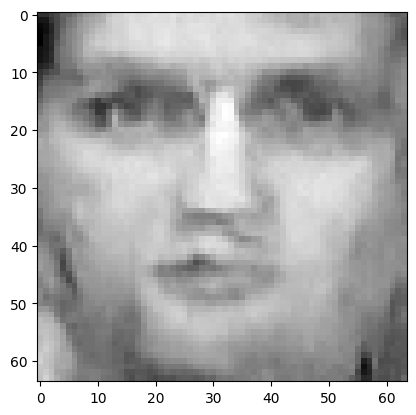

loss(generator):  0.06754304468631744
tensor([[1.7337e-05, 3.7768e-08, 1.2252e-05, 7.2273e-07, 1.6084e-04, 3.5139e-05,
         2.9465e-03, 1.4500e-06, 9.3469e-01, 1.3368e-02, 5.0812e-06, 1.3345e-05,
         3.3032e-04, 1.5578e-08, 6.8672e-07, 3.0300e-04, 6.4996e-05, 3.8990e-03,
         1.4645e-06, 2.3627e-05, 4.7178e-07, 4.2096e-05, 2.8692e-04, 1.5367e-05,
         2.0300e-03, 5.3593e-10, 3.0075e-07, 5.5902e-06, 1.9753e-03, 6.0471e-03,
         1.0948e-05, 3.1218e-08, 9.2948e-03, 2.9876e-08, 3.8465e-03, 6.1744e-05,
         2.6599e-07, 1.1035e-02, 8.7846e-06, 9.4670e-03]],
       grad_fn=<SoftmaxBackward>)


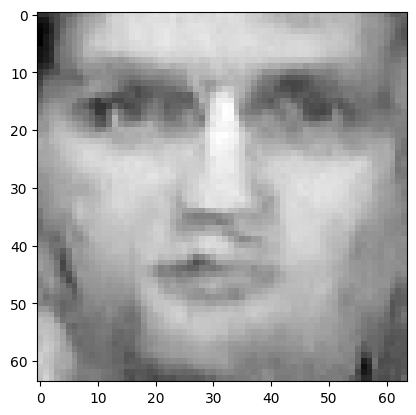

loss(generator):  0.06475915759801865
tensor([[1.6074e-05, 3.5259e-08, 1.1943e-05, 7.0368e-07, 1.5531e-04, 3.2775e-05,
         2.8221e-03, 1.3438e-06, 9.3729e-01, 1.3006e-02, 4.8483e-06, 1.2797e-05,
         3.1367e-04, 1.4668e-08, 6.5646e-07, 2.8208e-04, 6.3804e-05, 3.5816e-03,
         1.3941e-06, 2.2957e-05, 4.6007e-07, 4.1775e-05, 2.8358e-04, 1.4522e-05,
         1.9201e-03, 5.1787e-10, 2.8778e-07, 5.4812e-06, 1.9243e-03, 5.8007e-03,
         1.0708e-05, 2.9099e-08, 9.0106e-03, 2.8572e-08, 3.7037e-03, 5.8068e-05,
         2.6159e-07, 1.0598e-02, 8.5117e-06, 8.9958e-03]],
       grad_fn=<SoftmaxBackward>)


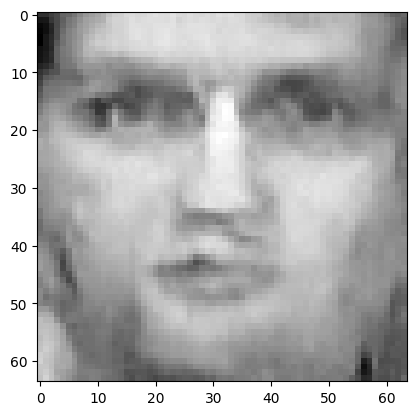

loss(generator):  0.06211135908961296
tensor([[1.4941e-05, 3.2955e-08, 1.1666e-05, 6.8669e-07, 1.4987e-04, 3.0568e-05,
         2.7042e-03, 1.2472e-06, 9.3978e-01, 1.2657e-02, 4.6280e-06, 1.2293e-05,
         2.9827e-04, 1.3850e-08, 6.2763e-07, 2.6234e-04, 6.2743e-05, 3.2883e-03,
         1.3289e-06, 2.2299e-05, 4.4965e-07, 4.1500e-05, 2.8080e-04, 1.3733e-05,
         1.8177e-03, 5.0206e-10, 2.7590e-07, 5.3863e-06, 1.8769e-03, 5.5534e-03,
         1.0479e-05, 2.7154e-08, 8.7335e-03, 2.7352e-08, 3.5669e-03, 5.4555e-05,
         2.5813e-07, 1.0188e-02, 8.2598e-06, 8.5466e-03]],
       grad_fn=<SoftmaxBackward>)


In [18]:
optimize_ddpm_noise_eps(x_i_lr1, 10, 1, 1, target=8)

In [19]:
torch.save(x_i_lr1, 'attack8_lr1_30ep.pt')

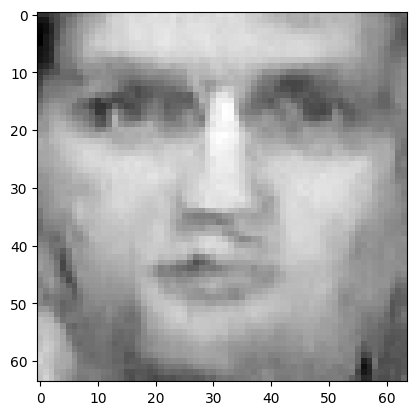

loss(generator):  0.05956481024622917
tensor([[1.3875e-05, 3.0814e-08, 1.1439e-05, 6.7086e-07, 1.4390e-04, 2.8262e-05,
         2.5797e-03, 1.1550e-06, 9.4217e-01, 1.2302e-02, 4.4163e-06, 1.1836e-05,
         2.8374e-04, 1.3118e-08, 5.9751e-07, 2.4286e-04, 6.1759e-05, 2.9986e-03,
         1.2670e-06, 2.1632e-05, 4.4138e-07, 4.1360e-05, 2.7752e-04, 1.2946e-05,
         1.7176e-03, 4.8735e-10, 2.6562e-07, 5.3049e-06, 1.8353e-03, 5.3074e-03,
         1.0262e-05, 2.5267e-08, 8.4647e-03, 2.6200e-08, 3.4239e-03, 5.0878e-05,
         2.5596e-07, 9.8313e-03, 8.0274e-06, 8.1307e-03]],
       grad_fn=<SoftmaxBackward>)


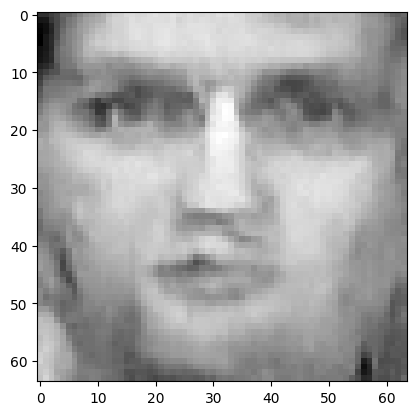

KeyboardInterrupt: 

In [20]:
optimize_ddpm_noise_eps(x_i_lr1, 20, 1, 1, target=8)

In [ ]:
torch.save(x_i_lr1, 'attack8_lr1_50ep.pt')